# Sampling a posterior

This notebook shows the basic usage of `cogwheel`.

We will choose an event, a waveform approximant and a prior and generate samples from the posterior distribution.

In [1]:
import sys
path_to_cogwheel = '/home/hschia/data/love/cogwheel'
sys.path.append(path_to_cogwheel)
sys.path.insert(0,"/home/hschia/data/love")
sys.path.insert(-1, "/home/hschia/PE/gw_detection_ias")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cogwheel import data
from cogwheel import gw_prior
from cogwheel import likelihood
from cogwheel import sampling
from cogwheel import waveform
from cogwheel import gw_plotting
from cogwheel.posterior import Posterior

import cogwheel
from cogwheel import posterior, data, sampling, gw_plotting
from cogwheel.gw_prior import IntrinsicAlignedSpinIASPrior
from cogwheel.likelihood import MarginalizedExtrinsicLikelihoodQAS
import cogwheel.waveform_models.quadrupole_dissipation_love
from cogwheel.waveform_models.quadrupole_dissipation_love import IntrinsicQuadrupoleDissipationLovePrior

# Functions that transform parameters
def eta(m1,m2):
    return m1*m2/(m1+m2)**2

def q_from_eta(eta):
    return (1-np.sqrt(1-4*eta)-2*eta)/(2*eta)

def mchirp(m1, m2):
    return (m1+m2)*eta(m1,m2)**0.6

def leff(m1, m2, l1, l2):
    return (16/13) * ((m1+12*m2)*m1**4 * l1 + (m2 + 12*m1)*m2**4 * l2) / (m1 + m2)**5

## Event options

For now, we will use one of the preprocessed `EventData` files included:

In [2]:
eventnames = sorted(path.name.removesuffix('.npz')
                    for path in data.DATADIR.glob('*.npz'))
print('Available eventnames:')
eventnames;

Available eventnames:


## Approximant options

Pick one from the keys below. Approximants with aligned spins require that the prior has aligned spins as well.

In [3]:
waveform.APPROXIMANTS

{'IMRPhenomD_NRTidalv2': Approximant(harmonic_modes=[(2, 2)], aligned_spins=True, tides=True, hplus_hcross_func=<function compute_hplus_hcross at 0x7f8b0f1379d0>),
 'IMRPhenomD': Approximant(harmonic_modes=[(2, 2)], aligned_spins=True, tides=False, hplus_hcross_func=<function compute_hplus_hcross at 0x7f8b0f1379d0>),
 'IMRPhenomXPHM': Approximant(harmonic_modes=[(2, 2), (2, 1), (3, 3), (3, 2), (4, 4)], aligned_spins=False, tides=False, hplus_hcross_func=<function compute_hplus_hcross at 0x7f8b0f1379d0>),
 'IMRPhenomXAS': Approximant(harmonic_modes=[(2, 2)], aligned_spins=True, tides=False, hplus_hcross_func=<function compute_hplus_hcross at 0x7f8b0f1379d0>),
 'IMRPhenomXP': Approximant(harmonic_modes=[(2, 2)], aligned_spins=False, tides=False, hplus_hcross_func=<function compute_hplus_hcross at 0x7f8b0f1379d0>),
 'quadrupole_dissipation_love': Approximant(harmonic_modes=[(2, 2)], aligned_spins=True, tides=False, hplus_hcross_func=<function compute_hplus_hcross_quadrupole_dissipation_lo

## Prior options

For now, we will choose one of the included `Prior` classes:

In [4]:
for prior_name, prior_class in gw_prior.prior_registry.items():
    print(f'{prior_name}:\n    {prior_class.__doc__}\n'
          .replace('\n    \n', '\n'))

IASPrior:
    Precessing, flat in chieff, uniform luminosity volume.

AlignedSpinIASPrior:
    Aligned spin, flat in chieff, uniform luminosity volume.

TidalIASPrior:
    Aligned spin, flat in tidal parameters, flat in chieff, uniform
    luminosity volume.

LVCPrior:
    Precessing, isotropic spins, uniform luminosity volume.

AlignedSpinLVCPrior:
    Aligned spin components from isotropic distribution, uniform
    luminosity volume.

IASPriorComovingVT:
    Precessing, flat in chieff, uniform comoving VT.

AlignedSpinIASPriorComovingVT:
    Aligned spin, flat in chieff, uniform comoving VT.

LVCPriorComovingVT:
    Precessing, isotropic spins, uniform comoving VT.

AlignedSpinLVCPriorComovingVT:
    Aligned spins from isotropic distribution, uniform comoving VT.

ExtrinsicParametersPrior:
    Uniform luminosity volume, fixed intrinsic parameters.

MarginalizedDistanceIASPrior:
    Prior for usage with ``MarginalizedDistanceLikelihood``.
    Similar to ``IASPrior`` except it does not

## Instantiating a `Posterior`

In [5]:
metadata = pd.read_csv(data.DATADIR/'events_metadata.csv', index_col=0)  # Chirp mass guesses

In [6]:
metadata['mchirp']['GW190707_093326']

9.94

In [23]:
metadata['mchirp'].keys()

Index(['GW150914', 'GW151012', 'GW151216', 'GW151226', 'GW170104', 'GW170121',
       'GW170202', 'GW170304', 'GW170403', 'GW170425', 'GW170608', 'GW170727',
       'GW170729', 'GW170809', 'GW170814', 'GW170817A', 'GW170818', 'GW170823',
       'GW190403_051519', 'GW190408_181802', 'GW190412', 'GW190413_052954',
       'GW190413_134308', 'GW190421_213856', 'GW190424_180648',
       'GW190426_190642', 'GW190503_185404', 'GW190512_180714',
       'GW190513_205428', 'GW190514_065416', 'GW190517_055101',
       'GW190519_153544', 'GW190521', 'GW190521_074359', 'GW190527_092055',
       'GW190602_175927', 'GW190620_030421', 'GW190630_185205',
       'GW190701_203306', 'GW190706_222641', 'GW190707_093326',
       'GW190708_232457', 'GW190719_215514', 'GW190720_000836',
       'GW190725_174728', 'GW190727_060333', 'GW190728_064510',
       'GW190731_140936', 'GW190803_022701', 'GW190805_211137', 'GW190814',
       'GW190828_063405', 'GW190828_065509', 'GW190909_114149',
       'GW190910_11280

In [24]:
# Choose from the above options:
eventname = 'GW200219_094415'
mchirp_guess = metadata['mchirp'][eventname]
approximant = 'quadrupole_dissipation_love'
prior_name = 'IntrinsicQuadrupoleDissipationLovePrior'
delta_tc = 0.1

post = Posterior.from_event(eventname, mchirp_guess, approximant, prior_name, 
                            prior_kwargs={'symmetrize_lnq': True, 'spin_quadrupole_rng':(-1000, 1000), 'tidal_dissipation_rng': (0, 10000), 'max_tidal_deformability': 1e4},
                            ref_wf_finder_kwargs={'time_range':{-delta_tc, delta_tc}})

Searching incoherent solution for GW200219_094415
Set intrinsic parameters, lnL = 32.459075608546044
Set time, lnL(L) = 18.678801741651476
Set sky location, lnL = 24.53400899974247
Set phase and distance, lnL = 24.53400899974247
Set mchirp_range = (10.358063697592641, 51.060180637927154)


TODO: Looks like likelihood pars do not contain new parameters?

In [25]:
post.likelihood.par_dic_0

{'d_luminosity': 2201.0582443934104,
 'dec': -0.39245253502861277,
 'f_ref': 59.0,
 'iota': 1.0,
 'l1': 0.0,
 'l2': 0.0,
 'm1': 33.893634916165446,
 'm2': 21.63905845480487,
 'phi_ref': -1.109159502857805,
 'psi': 0.0,
 'ra': 0.3329138313732969,
 's1x_n': 0.0,
 's1y_n': 0.0,
 's1z': -0.3720753838037964,
 's2x_n': 0.0,
 's2y_n': 0.0,
 's2z': -0.3720753838037964,
 't_geocenter': 0.06986479763992832}

In [26]:
# debug = cogwheel.posterior.debug
# debug['likelihood']
# debug['prior'].standard_params

Things you might want to double-check at this point:

* Did the maximizer find a high likelihood solution ($\log \mathcal{L} \approx \rm{SNR}^2 / 2$)?
* Is the automatically chosen `mchirp_range` ok?
* Are the default `q_min` and `dt0` ok?

In [27]:
post.likelihood.lnlike(post.likelihood.par_dic_0), np.sqrt(post.likelihood.lnlike(post.likelihood.par_dic_0)*2)

(6.873697639265192, 3.7451456212097316)

In [28]:
post.prior.get_init_dict()

{'mchirp_range': array([10.3580637 , 51.06018064]),
 'q_min': 0.05000000000000001,
 'symmetrize_lnq': True,
 'spin_quadrupole_rng': array([-1000.,  1000.]),
 'tidal_dissipation_rng': array([    0., 10000.]),
 'max_tidal_deformability': 10000.0,
 'f_ref': 59.0}

In [29]:
par_dic_0 = post.likelihood.par_dic_0
par_dic_0

{'d_luminosity': 2201.0582443934104,
 'dec': -0.39245253502861277,
 'f_ref': 59.0,
 'iota': 1.0,
 'l1': 0.0,
 'l2': 0.0,
 'm1': 33.893634916165446,
 'm2': 21.63905845480487,
 'phi_ref': -1.109159502857805,
 'psi': 0.0,
 'ra': 0.3329138313732969,
 's1x_n': 0.0,
 's1y_n': 0.0,
 's1z': -0.3720753838037964,
 's2x_n': 0.0,
 's2y_n': 0.0,
 's2z': -0.3720753838037964,
 't_geocenter': 0.06986479763992832}

In [30]:
mchirp(par_dic_0['m1'], par_dic_0['m2']), metadata['mchirp'][eventname]

(23.458711640198533, 43.3)

In [31]:
%%time

# Run the sampler and postprocess:
pym = sampling.PyMultiNest(post, sample_prior=False)
pym.run_kwargs['n_live_points'] = 128

parentdir = '/home/hschia/data/love/pe/pe_plots'  # Directory that will contain parameter estimation runs
rundir = pym.get_rundir(parentdir)
print('PE rundir:', rundir)
pym.run(rundir)


PE rundir: /home/hschia/data/love/pe/pe_plots/IntrinsicQuadrupoleDissipationLovePrior/GW200219_094415/run_0
 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  128
 dimensionality =   10
 *****************************************************
 ln(ev)=  -57.116889477791482      +/-  0.21666625278890389     
 Total Likelihood Evaluations:         5801
 Sampling finished. Exiting MultiNest
CPU times: user 14min 37s, sys: 1h 13min 31s, total: 1h 28min 9s
Wall time: 1min 53s


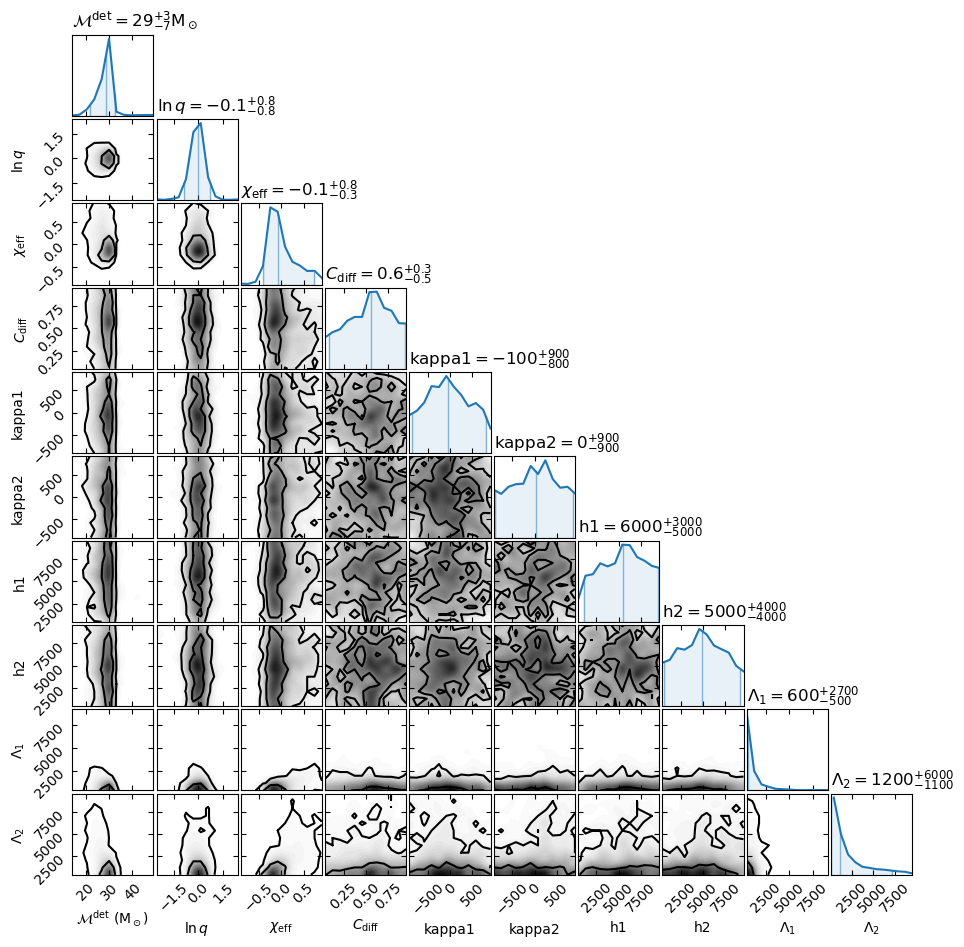

In [32]:
samples = pd.read_feather(rundir/'samples.feather')
gw_plotting.CornerPlot(samples[post.prior.sampled_params]).plot()

In [33]:
samples.keys()

Index(['mchirp', 'lnq', 'chieff', 'cumchidiff', 'kappa1', 'kappa2', 'h1', 'h2',
       'l1', 'l2', 'm1', 'm2', 's1z', 's2z', 'f_ref', 'd_luminosity', 'dec',
       'lon', 'phi_ref', 'psi', 'iota', 't_geocenter', 'lnl_marginalized',
       'lnl', 'h_h', 'n_effective', 'n_qmc', 'ra'],
      dtype='object')

In [34]:
samples['hs'] = (samples['m1']**3*samples['h1'] + samples['m2']**3*samples['h2'])/(samples['m1']+samples['m2'])**3
samples['ha'] = (samples['m1']**3*samples['h1'] - samples['m2']**3*samples['h2'])/(samples['m1']+samples['m2'])**3
samples['leff'] = leff(samples['m1'], samples['m2'], samples['l1'], samples['l2'])
samples['ks'] = (samples['kappa1']+samples['kappa2'])/2
samples['ka'] = (samples['kappa1']-samples['kappa2'])/2

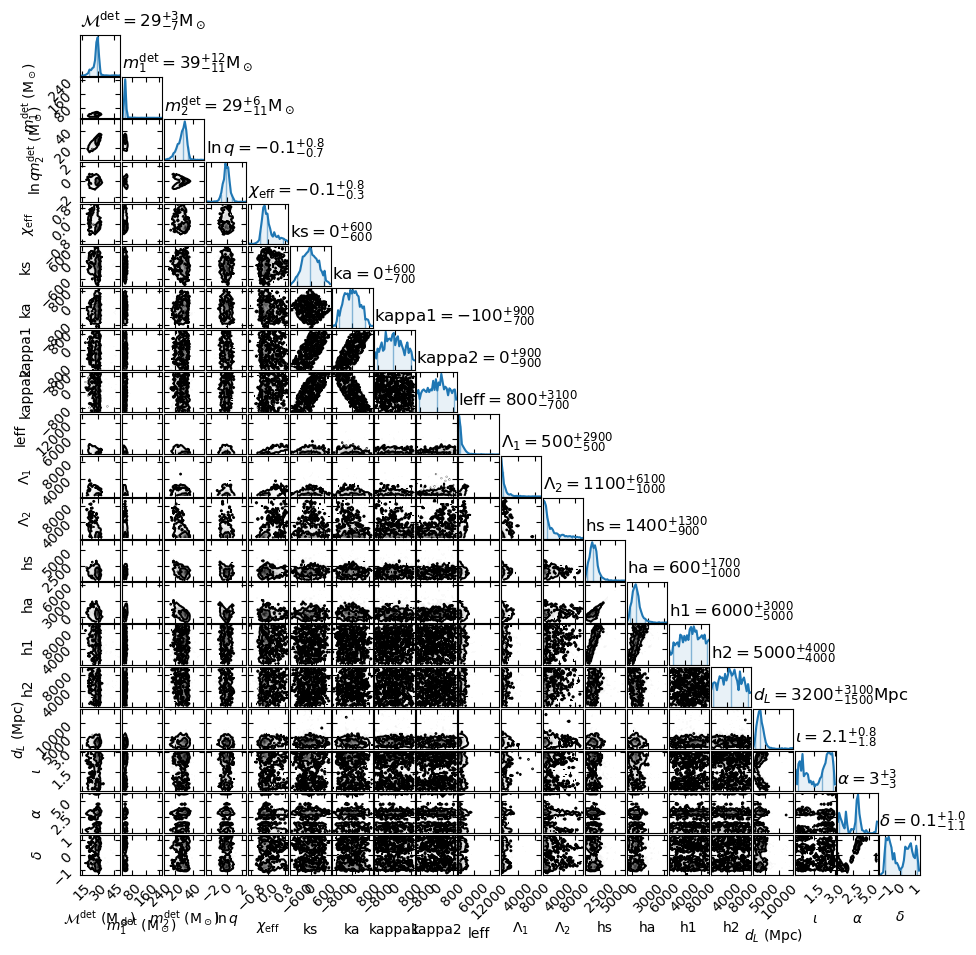

In [35]:
plot_params = ['mchirp', 'm1', 'm2', 'lnq', 'chieff', 'ks', 'ka', 'kappa1', 'kappa2', 'leff', 'l1', 'l2', 'hs', 'ha', 'h1', 'h2', 'd_luminosity', 'iota', 
               'ra', 'dec']
cp = gw_plotting.CornerPlot(samples[plot_params], bins=30)

cp.plot(tightness=.999, max_n_ticks=3)
# cp.scatter_points(par_dic, colors=['C3'])

In [38]:
sample = dict(samples.sample().iloc[0])

In [41]:
sample

{'mchirp': 28.07077008479914,
 'lnq': -0.31845967623312976,
 'chieff': -0.3371806050486821,
 'cumchidiff': 0.5041261414538282,
 'kappa1': 726.3492603147365,
 'kappa2': -186.1878279860723,
 'h1': 3471.4298892268002,
 'h2': 6561.021672639779,
 'l1': 78.49126722265419,
 'l2': 212.50757568606906,
 'm1': 37.90613115153457,
 'm2': 27.567931487935198,
 's1z': -0.4228426177346999,
 's2z': -0.2193946373564135,
 'f_ref': 59.0,
 'd_luminosity': 1456.0678201315368,
 'dec': -0.8570655535231918,
 'lon': 2.3612390076010485,
 'phi_ref': 0.18967528271468237,
 'psi': 3.1214505881944854,
 'iota': 1.7901621548746862,
 't_geocenter': 0.06631071796683993,
 'lnl_marginalized': 11.009070891002494,
 'lnl': 30.116682965617805,
 'h_h': 51.926114662906755,
 'n_effective': 62.81981685438147,
 'n_qmc': 2048.0,
 'ra': 1.2247044362324218,
 'hs': 1163.3935399515494,
 'ha': 183.88970268499722,
 'leff': 121.69177259591866,
 'ks': 270.0807161643321,
 'ka': 456.2685441504044}

In [48]:
h1_arr = np.linspace(0, 1000)

In [55]:
[post.likelihood.lnlike_fft(sample | {'s1x_n':0, 's1y_n':0, 's2x_n':0, 's2y_n':0, 'l2':h1})  for h1 in h1_arr]

[29.97935434831153,
 30.04208160509657,
 30.101553399459096,
 30.15771902828855,
 30.151993142199935,
 30.136378013284325,
 30.11008319593499,
 30.07184386745347,
 30.060429846386665,
 30.034293891337594,
 30.009098366851322,
 29.96626888373543,
 29.931632972078837,
 29.895758812938613,
 29.8433607089476,
 29.797856598202394,
 29.745890644689005,
 29.70139631251779,
 29.65018399475423,
 29.58660354535488,
 29.522838224323838,
 29.45890261946551,
 29.392814629403745,
 29.315515145272702,
 29.237916297820664,
 29.151445023734574,
 29.064919811448956,
 28.96508382182254,
 28.863703727699917,
 28.754463329984702,
 28.64896907126828,
 28.53739981533831,
 28.415322992513367,
 28.29000439642285,
 28.15757035756047,
 28.015537044993938,
 27.87262844542441,
 27.729295570900863,
 27.583504176310825,
 27.42546293514054,
 27.26790573424994,
 27.108746121784563,
 26.954108342200794,
 26.78708056352281,
 26.615020519786814,
 26.448568131299957,
 26.27026866884534,
 26.097855207734206,
 25.9212380795